<img src="https://github.com/alan-barzilay/NLPortugues/blob/master/imagens/logo_nlportugues.png?raw=true"  style="height:65%" align="right">


# Lista10 - BERT
**Nome:**  Wesley Seidel Carvalho

**Numero Usp:** 6544342









______________




O objetivo desta lista é fazer com que vocês se familiarizem com o BERT por meio da biblioteca HuggingFace. Novamente, as questões 1 2 e 3 podem ser copiadas de listas anteriores.

In [1]:
!pip install transformers

     |████████████████████████████████| 1.3 MB 556 kB/s eta 0:00:01
     |████████████████████████████████| 883 kB 2.8 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 2.6 MB/s eta 0:00:01
     |████████████████████████████████| 2.9 MB 2.8 MB/s eta 0:00:01
  Using cached filelock-3.0.12-py3-none-any.whl (7.6 kB)
  Created wheel for sacremoses: filename=sacremoses-0.0.43-py3-none-any.whl size=893259 sha256=11db6d01e7f67db541c02ec209793ef97c0bf53965c0b04313e086649374b911
  Stored in directory: /mnt/dados/home/wseidel/.cache/pip/wheels/7b/78/f4/27d43a65043e1b75dbddaa421b573eddc67e712be4b1c80677
Successfully built sacremoses
You should consider upgrading via the '/mnt/dados/home/wseidel/envs/usp-MAC5725c/bin/python -m pip install --upgrade pip' command.


In [2]:
!nvidia-smi

zsh:1: command not found: nvidia-smi


In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from transformers import (
    BertTokenizer,
    TFBertForSequenceClassification,
    TFTrainer,
    TFTrainingArguments,
)

### Importando os dados como um dataframe

Para esta lista nós utilizaremos o dataset **B2W-Reviews01** que consiste em avaliações de mais de 130k compras online no site Americanas.com e [esta disponivel no github](https://github.com/b2wdigital/b2w-reviews01) sob a licensa CC BY-NC-SA 4.01.

In [4]:
b2wCorpus = pd.read_csv("https://raw.githubusercontent.com/abarbosa94/NLPortugues/master/Semana%2009/data/b2w-10k.csv")
b2wCorpus.head()

,submission_date,reviewer_id,product_id,product_name,product_brand,site_category_lv1,site_category_lv2,review_title,overall_rating,recommend_to_a_friend,review_text,reviewer_birth_year,reviewer_gender,reviewer_state,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18
0,2018-01-01 00:11:28,d0fb1ca69422530334178f5c8624aa7a99da47907c44de...,132532965,Notebook Asus Vivobook Max X541NA-GO472T Intel...,NaN,Informática,Notebook,Bom,4,Yes,Estou contente com a compra entrega rápida o ú...,1958,F,RJ,NaN,NaN,NaN,NaN,NaN
1,2018-01-01 00:13:48,014d6dc5a10aed1ff1e6f349fb2b059a2d3de511c7538a...,22562178,Copo Acrílico Com Canudo 500ml Rocie,NaN,Utilidades Domésticas,"Copos, Taças e Canecas","Preço imbatível, ótima qualidade",4,Yes,"Por apenas R$1994.20,eu consegui comprar esse ...",1996,M,SC,NaN,NaN,NaN,NaN,NaN
2,2018-01-01 00:26:02,44f2c8edd93471926fff601274b8b2b5c4824e386ae4f2...,113022329,Panela de Pressão Elétrica Philips Walita Dail...,philips walita,Eletroportáteis,Panela Elétrica,ATENDE TODAS AS EXPECTATIVA.,4,Yes,SUPERA EM AGILIDADE E PRATICIDADE OUTRAS PANEL...,1984,M,SP,NaN,NaN,NaN,NaN,NaN
3,2018-01-01 00:35:54,ce741665c1764ab2d77539e18d0e4f66dde6213c9f0863...,113851581,Betoneira Columbus - Roma Brinquedos,roma jensen,Brinquedos,Veículos de Brinquedo,presente mais que desejado,4,Yes,MEU FILHO AMOU! PARECE DE VERDADE COM TANTOS D...,1985,F,SP,NaN,NaN,NaN,NaN,NaN
4,2018-01-01 01:00:28,7d7b6b18dda804a897359276cef0ca252f9932bf4b5c8e...,131788803,"Smart TV LED 43"" LG 43UJ6525 Ultra HD 4K com C...",lg,TV e Home Theater,TV,"Sem duvidas, excelente",5,Yes,"A entrega foi no prazo, as americanas estão de...",1994,M,MG,NaN,NaN,NaN,NaN,NaN


In [5]:
b2wCorpus["review_text"]

0       Estou contente com a compra entrega rápida o ú...
1       Por apenas R$1994.20,eu consegui comprar esse ...
2       SUPERA EM AGILIDADE E PRATICIDADE OUTRAS PANEL...
3       MEU FILHO AMOU! PARECE DE VERDADE COM TANTOS D...
4       A entrega foi no prazo, as americanas estão de...
                              ...                        
9994    Celular muito rápido, com processador e armaze...
9995    achei o produto muito frágil, o material veio ...
9996    Uma porcaria pois ñ recebi ñ recomendo pra nin...
9997    Maquina excelente,super pratica. recomendo.ent...
9998    Agradeço pelo compromisso, obrigado. ,...........
Name: review_text, Length: 9999, dtype: object


### Pré-processamento
Seria util nos livrarmos das colunas que não são relevantes para o nosso problema e tambem verificar se não tem nada de esquisito nas colunas que vamos utilizar. 
Por exemplo, se fossemos utilizar a coluna "reviewer_gender" nós precisariamos nos livrar desses valores esquisitos:

In [6]:
b2wCorpus["reviewer_gender"].value_counts()

M                                                                         5033
F                                                                         4624
1970                                                                         1
Ocorrência: Z-Devolução Em Andamento Ao Cd de São Paulo 22/12/17 16:12       1
                                                                             1
Name: reviewer_gender, dtype: int64

## <font color='blue'>Questão 1 </font>

a) Selecione apenas as colunas relevantes: "review_text" e "recommend_to_a_friend". 

b) Converta a coluna "recommend_to_a_friend" de uma coluna de `str` para uma coluna de `int`:

- "Yes"-> 1
- "No" -> 0


In [7]:
# Seu código aqui
df = b2wCorpus[["review_text", "recommend_to_a_friend"]]
df = df.assign(recommend_to_a_friend_new=0)
df['recommend_to_a_friend_new'] = df.recommend_to_a_friend.apply(lambda word : 1 if word == 'Yes' else 0)

# df.head()
df.groupby(by="recommend_to_a_friend_new").count()

,review_text,recommend_to_a_friend
recommend_to_a_friend_new,,
0,2548,2548
1,7451,7451


### Separando em teste e treino
## <font color='blue'>Questão 2 </font>

Agora com o dataset já pré-processado, separe o em 2 partes, um conjunto de teste e um conjunto de treino. Novamente você pode utilizar a função [train_test_split()](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) do Scikit-Learn como na lista passada.

In [8]:
# Seu código aqui
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(df['review_text'].values, df['recommend_to_a_friend_new'].values, test_size=0.20) # , random_state=17)

### Tokenizando

Para aplicar o processo de _Tokenize_ dos nossos dados, diferente das listas anteriores, utilizaremos a classe [BertTokenizer](https://huggingface.co/transformers/master/model_doc/bert.html#berttokenizer) da biblioteca [transformers](https://github.com/huggingface/transformers) do HuggingFace.

Para isso, veja o exemplo abaixo:


Como é possível ver, o resultado gera um dicionário com 3 chaves, representando diferentes tensores:

    - input_ids (os arrays de entrada convertidos para inteiro)
    - token_type_ids (Indicação se pertence a sentença A ou B [0 é sentença A e 1 é sentença B])
    - attention_mask (indicando quais tokens foram mascarados. Como todos os tokens **não** foram mascarados, o valor aqui sempre é 1)

## <font color='blue'>Questão 3 </font>

Aplique o tokenizer nos dados de treino e teste, gerando duas variáveis **encoded_train** e **encoded_test**, considerando o max_length como o tamanho da sentença ideal. Plotamos um histograma do comprimento dos reviews para lhe auxiliar nessa decisão.

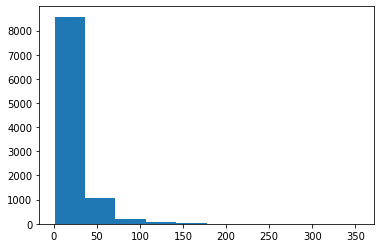

In [9]:
plt.hist([len(linha.split()) for linha in b2wCorpus["review_text"]])
plt.show()

In [13]:
REF_MODEL = 'neuralmind/bert-base-portuguese-cased'
tokenizer = BertTokenizer.from_pretrained(REF_MODEL)

In [ ]:
# text.values.tolist()
# x_train.tolist()
# [ [t] for t in x_train[0:10]]
# x_train[0:10]
# np.expand_dims(x_train[0:10], axis=1).tolist()

In [14]:
# Seu código aqui
SEQ_LEN=50

encoded_train = tokenizer(
    np.expand_dims(x_train, axis=1).tolist(),
    text_pair=None,
    is_split_into_words=True,
    padding="max_length",
    truncation=True,
    max_length=SEQ_LEN,
    pad_to_max_length=True,
    return_tensors='tf'
)
# encoded_text_labels = np.array([0,0,1])
# encoded_train

In [15]:
# Seu código aqui
encoded_test =  tokenizer(
    np.expand_dims(x_test, axis=1).tolist(),
    text_pair=None,
    is_split_into_words=True,
    padding="max_length",
    truncation=True,
    max_length=SEQ_LEN,
    pad_to_max_length=True,
    return_tensors='tf'
)

In [16]:
print( "Shape do treino:", encoded_train['input_ids'].shape)
print( "Shape do teste.:", encoded_test['input_ids'].shape)
encoded_test.keys()
# print( "Shape do teste.:", encoded_test['attention_mask'].shape)

Shape do treino: (7999, 50)
Shape do teste.: (2000, 50)


dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

### Montando o modelo

Para montar o modelo, iremos utilizar a classe TFBertForSequenceClassification, do HuggingFace

Aqui tem um exemplo de código para vocês seguirem!


## Treinando e avaliando seu modelo

###  <font color='blue'>Questão 4 </font>

Defina e treine seu modelo.

**Lembre-se de tambem adicionar os dados de validação do modelo**

In [18]:
!pip install torch

     |████████████████████████████████| 776.8 MB 42 bytes/s a 0:00:01     |█████                           | 121.7 MB 3.3 MB/s eta 0:03:19     |█████▏                          | 125.3 MB 2.7 MB/s eta 0:04:06     |███████▍                        | 178.7 MB 2.7 MB/s eta 0:03:42     |█████████                       | 218.3 MB 3.4 MB/s eta 0:02:44     |█████████▌                      | 231.7 MB 3.2 MB/s eta 0:02:52     |██████████████████████████████▌ | 740.6 MB 4.1 MB/s eta 0:00:09     |██████████████████████████████▋ | 742.1 MB 4.1 MB/s eta 0:00:09
  Using cached typing_extensions-3.7.4.3-py3-none-any.whl (22 kB)
  Using cached future-0.18.2.tar.gz (829 kB)
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491059 sha256=1484c7ffa4b559b51170c6899d2218b0ac5625a239cff0a2bb2c8003faebe252
  Stored in directory: /mnt/dados/home/wseidel/.cache/pip/wheels/8e/70/28/3d6ccd6e315f65f245da085482a2e1c7d14b90b30f239e2cf4
Successfully built future
You should consider upgrading via

In [19]:
bert_model = TFBertForSequenceClassification.from_pretrained(REF_MODEL, from_pt=True, num_labels=2)
input_ids = tf.keras.layers.Input(shape=(SEQ_LEN,), name='input_token', dtype='int32')
input_masks_ids = tf.keras.layers.Input(shape=(SEQ_LEN,), name='masked_token', dtype='int32')

X = bert_model(input_ids, input_masks_ids)

model = tf.keras.Model(inputs=[input_ids, input_masks_ids], outputs = X)
model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the P

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_token (InputLayer)        [(None, 50)]         0                                            
__________________________________________________________________________________________________
masked_token (InputLayer)       [(None, 50)]         0                                            
__________________________________________________________________________________________________
tf_bert_for_sequence_classifica ((None, 2),)         108924674   input_token[0][0]                
Total params: 108,924,674
Trainable params: 108,924,674
Non-trainable params: 0
__________________________________________________________________________________________________


In [20]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5, epsilon=1e-06)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
callbacks = [tf.keras.callbacks.EarlyStopping(patience=3)]

model.compile(optimizer, loss, metrics=["acc"])

In [21]:
# Seu código aqui
history = model.fit(
    [encoded_train["input_ids"], encoded_train["attention_mask"]],
    y_train,
    batch_size=256,
    epochs=10,
    callbacks=callbacks,
    validation_data=([encoded_test["input_ids"], encoded_test["attention_mask"]], y_test),
    verbose=True
)

Epoch 1/10
13/32 [===========>..................] - ETA: 29:15 - loss: 0.6160 - acc: 0.6614

KeyboardInterrupt: 